# **Identification de langues avec des :**
>### **- '*Sparse*' Bag Of Words**
>### **- Tokenisations BERT ou Tiktoken**
>### **- CountVectorizer utilisant une tokenisation '*custom*'**
>### **- Classificateurs Naïve Bayes et Gradiant Boosting**

## **1 - Contruction des classificateurs**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import joblib
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer

# Choix de la Tokenisation (False = BERT, True Tiktoken)
titoken_tokenization = True

# Ce parametre permet éventuellement d'équilibrer de nombre de phrase par langue.
# Si ce parametre est très grand, tout le corpus sera lu. 
nb_phrase_lang = 500000

import warnings
warnings.filterwarnings('ignore')

#### **Lectures des phrases de "sentences.csv", et de leur étiquette "Langue" pour les langues sélectionnées**

In [2]:
# Ouvrir le fichier d'entrée en mode lecture
def create_lang_df(path):
    df = pd.read_csv(path, index_col ='id')
    return df

df_big = create_lang_df('../data/multilingue/sentences.csv')
lan_code = ['eng','fra','deu','spa','ita']
df = pd.DataFrame(columns=df_big.columns)
for i in range(len(lan_code)):
    df= pd.concat([df, df_big[df_big['lan_code']==lan_code[i]].iloc[:nb_phrase_lang]])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
n_rows = len(df)
print('Nombre de lignes de sentence.csv:',n_rows)
df

Nombre de lignes de sentence.csv: 1750000


,lan_code,sentence
0,spa,El poeta intentó suicidarse en su estudio.
1,fra,Je me suis sentie un peu prise de vertige.
2,deu,Ich reise im kommenden Jahr nach Rio.
3,ita,Spero che verrete alla mia festa di compleanno.
4,ita,La telefonata era un trucco per farlo uscire d...
...,...,...
1749995,eng,What a strange message! There is no sender and...
1749996,ita,Noi ci stiamo per fare una doccia.
1749997,eng,Two girls were hanging on to Tom's arms.
1749998,fra,Tu dois cesser de t'énerver après des choses q...


#### **Réalisation d'un jeu de données d'entrainement et de test**

In [3]:
# créer 2 dataframes: 1 train (70% des phrases) et 1 test (30% des phrases)
n_train = int(n_rows*0.7)
df_train = df.iloc[:n_train].sample(frac=1, random_state=42).reset_index(drop=True)
df_test = df.iloc[n_train:].sample(frac=1, random_state=24).reset_index(drop=True)
pd.set_option('display.max_colwidth', 150)
display(df_train)
nb_phrases_lang =[]
for l in lan_code:
    nb_phrases_lang.append(sum(df_train['lan_code']==l))
print("Nombre de phrases par langue dans le jeu de données Train ",lan_code,":",nb_phrases_lang)

,lan_code,sentence
0,spa,Ella posee muchos libros valiosos.
1,ita,Penso che dovresti tornare a Boston.
2,eng,Tom killed himself.
3,eng,Could I use your phone?
4,spa,Veremos los que quiere Tom.
...,...,...
1224995,spa,La mujer sabia vale más que la mujer bonita.
1224996,deu,Er weiß überhaupt nichts über dieses Buch.
1224997,spa,"No me acusan, me insultan; no me combaten, me calumnian, y no me dan el derecho de defensa."
1224998,ita,Vincete le partite con rigori che neanche ci sono!


Nombre de phrases par langue dans le jeu de données Train  ['eng', 'fra', 'deu', 'spa', 'ita'] : [244836, 245461, 244737, 244903, 245063]


#### **Selection du tokenizer** en fonction de la variable titoken_tokenization

In [4]:
# Selection du tokenizer
if titoken_tokenization:
    import tiktoken
    tokenizer = tiktoken.get_encoding("cl100k_base")
else:
    from transformers import BertTokenizerFast
    tokenizer = BertTokenizerFast.from_pretrained('bert-base-multilingual-uncased')

#### **Préparation de la vectorisation par CountVectorizer**

In [5]:
# Les 2 fonctions suivantes sont nécéssaires afin de sérialiser ces parametre de CountVectorizer
# et ainsi de sauvegarder le vectorizer pour un un usage ultérieur sans utiliser X_train pour  le réinitialiser
def custom_tokenizer(text):
    tokens = tokenizer.encode(text)  # Cela divise le texte en mots
    return tokens

def custom_preprocessor(text):
    return text

# CountVectorizer a une liste de phrase en entrée.
# Cette fonction met les données d'entrée dans le bon format
def format_to_vectorize(data):
    X_tok = []
    if "DataFrame" in str(type(data)):sentences = df.tolist()
    elif "str" in str(type(data)):
        sentences =[data]
    else: sentences = data
                          
    for sentence in sentences:
        X_tok.append(sentence) # ('¤'.join([tokenizer.decode([ids]) for ids in tokenizer.encode(sentence)])+'¤')
    return X_tok

#### **Création de la fonction Vectorizer et de la fonction de création d'un Bags  Of Worlds**

In [6]:
# Création d'un vectorizer et du sparse BOW (X_train) avec le nombre d'apparitions
global vectorizer, dict_ids, dict_token

def create_vectorizer(X_train_tok):
    global vectorizer, dict_ids, dict_token
    
    # token_pattern = r"[a-zA-Z0-9\s\.\,\?\:\;]+" 
    # vectorizer = CountVectorizer(analyzer="word", tokenizer=lambda x: tokenizer.encode(x), preprocessor=lambda x: x) #,token_pattern=token_pattern
    vectorizer = CountVectorizer(analyzer="word", tokenizer=custom_tokenizer, preprocessor=custom_preprocessor) #,token_pattern=token_pattern
    vectorizer.fit(X_train_tok)
    
    # Création de dictionnaire des Token et des ids 
    dict_token = {tokenizer.decode([cle]): cle for cle, valeur in vectorizer.vocabulary_.items()}
    dict_ids = {cle: tokenizer.decode([cle]) for cle, valeur in vectorizer.vocabulary_.items()} #dict_ids.items()}
    return 

def create_BOW(data, vectorizer_to_create=False):
    global vectorizer
    
    X_tok = format_to_vectorize(data)
    if vectorizer_to_create:
        create_vectorizer(X_tok)
    X = vectorizer.transform(X_tok)
    return X

#### **Création du BOW Train**

In [7]:
X_train = create_BOW(df_train['sentence'], True)
y_train = df_train['lan_code'].values.tolist()

#### **Création du BOW Test**


In [8]:
X_test = create_BOW(df_test['sentence'])
y_test = df_test['lan_code'].values.tolist()

#### **Sauvegarde/Chargement du vectorizer**

In [9]:
# Definition de fonction de sauvegarde et chargement du dictionnaire des tokens utilisés
def save_vectorizer(vectorizer):
    if titoken_tokenization: path = '../data/vectorizer_tiktoken.pkl'
    else: path = '../data/vectorizer_BERT.pkl' 
    joblib.dump(vectorizer, path)

def load_vectorizer():
    global dict_token, dict_ids, nb_token
    
    if titoken_tokenization: path = '../data/vectorizer_tiktoken.pkl'
    else: path = '../data/vectorizer_BERT.pkl'
    vectorizer = joblib.load(path)
    dict_token = {tokenizer.decode([cle]): cle for cle, valeur in vectorizer.vocabulary_.items()}
    dict_ids = {cle: tokenizer.decode([cle]) for cle, valeur in vectorizer.vocabulary_.items()} #dict_ids.items()}
    nb_token = len(vectorizer.vocabulary_)
    return vectorizer

In [10]:
# save_vectorizer(vectorizer)

# vectorizer = load_vectorizer()

#### **Definition d'une fonction ids->colonne de X_train et col->ids**

In [11]:
def ids2col(list_ids):
    d = dict(vectorizer.vocabulary_.items())
    list_col = []
    for ids in list_ids:
        list_col.append(d[ids])
    return list_col

def col2ids(list_col):
    d = dict(vectorizer.vocabulary_.items())
    list_ids = []
    for col in list_col:
        for ids, c in d.items():
            if col==c:
                list_ids.append(ids)
                break
    return list_ids

#### **Création d'un dictionnaire des tokens avec leur fréquence d'apparition dans Train**
#### **Définition d'une liste de token trié par fréquence d'apparition**

In [12]:
freq = X_train.sum(axis=0)
list_ids = col2ids(range(len(dict_ids)))
list_token = [tokenizer.decode([ids]) for ids in list_ids]
dict_freq = dict(zip(list_token,freq.tolist()[0]))
dict_freq = dict(sorted(dict_freq.items(), key=lambda x: x[1], reverse=True))

def ids2token(ids):
    for token, valeur in dict_ids.items():
        if valeur == ids:
            token_trouvee = token
            break
    return token_trouvee

nb_token = len(vectorizer.vocabulary_)
print("Nombre de tokens :",nb_token)

# Définition d'une liste 'écrite' des tokens : decoded_keys
# decoded_keys = [tokenizer.decode([ids]) for ids in [ids2token(key) for key in list(dict_freq.keys())]]
decoded_keys = list(dict_freq.keys())
print("Liste des 50 tokens les plus fréquents:",decoded_keys[:50])

# vocab_size = max(max(row) for row in X_train) + 1

Nombre de tokens : 43361
Liste des 50 tokens les plus fréquents: ['.', ',', '?', ' a', ' de', ' la', ' que', 'Tom', ' un', ' the', ' in', ' to', 'I', "'", 'i', ' le', ' en', ' es', 'é', ' l', '!', 'o', ' ist', ' pas', ' Tom', ' me', ' di', 'Ich', ' is', 'Je', ' nicht', ' you', ' die', ' à', ' el', ' est', 'a', 'en', ' d', ' è', ' ne', ' se', ' no', ' una', ' zu', 'Il', '¿', ' of', ' du', "'t"]


#### **Choix du nom du fichier de sauvegarde du classifieur**

In [13]:
def get_file_name(titoken_tokenization, classifier):
    if titoken_tokenization:
        return "id_lang_tiktoken_"+classifier+"_sparse.pkl"
    else:
        return "id_lang_BERT_"+classifier+"_sparse.pkl"

#### **Création d'un classificateur avec l'algorithme Naïve Bayes**

In [14]:
from sklearn import naive_bayes

# On definit le classificateur Naive Bayes et on l'entraine sur les données Train:
# clf_nb = naive_bayes.MultinomialNB()  # BernoulliNB() # MultinomialNB() 
# clf_nb.fit(X_train, y_train)

# Save the model to a file
# joblib.dump(clf_nb, "../data/"+get_file_name(titoken_tokenization,"nb")) ######### 

In [15]:
# Chargement du classificateur sauvegardé
clf_nb = joblib.load("../data/"+get_file_name(titoken_tokenization,"nb"))

# Verification de l'efficacité du classificateur grace à la matrice confusion
y_pred_nb = clf_nb.predict(X_test)
accuracy_naive_bayes = accuracy_score(y_test, y_pred_nb)
print("Matrice de confusion du classificateur Naïve Bayes")
display(pd.crosstab(y_test,y_pred_nb,rownames=['Classe réelle'], colnames=['Classe prédite']))
print("Accuracy Naïve Bayes = {:.3f}".format(accuracy_naive_bayes))

Matrice de confusion du classificateur Naïve Bayes


Classe prédite,deu,eng,fra,ita,spa
Classe réelle,,,,,
deu,105217,6,10,19,11
eng,43,105004,25,47,45
fra,6,5,104340,95,93
ita,5,6,28,104680,218
spa,16,3,61,252,104765


Accuracy Naïve Bayes = 0.998


#### **Création d'un classificateur avec l'algorithme Gradiant Boosting**

> Attention le training de cet algorithme peut être très long<br>
> Il peut être interessant de charger le modèle entrainé (si vous l'avez sauvez préalablement)

In [16]:
from sklearn.ensemble import GradientBoostingClassifier

# On definit le classificateur GradientBoosting et on l'entraine sur les données Train:
# clf_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=1, random_state=0).fit(X_train, y_train)

# Save the model to a file
# joblib.dump(clf_gb, "../data/"+get_file_name(titoken_tokenization,"gb")) ######### 

In [17]:
# Chargement du classificateur sauvegardé
clf_gb = joblib.load("../data/"+get_file_name(titoken_tokenization,"gb"))

# Verification de l'efficacité du classificateur grace à la matrice confusion
y_pred_gb = clf_gb.predict(X_test)
accuracy_gradiant_boosting = accuracy_score(y_test, y_pred_gb)
print("Matrice de confusion du classificateur Gradiant Boosting")
display(pd.crosstab(y_test,y_pred_gb,rownames=['Classe réelle'], colnames=['Classe prédite']))
print("Accuracy Gradiant Boosting = {:.3f}".format(accuracy_gradiant_boosting))

Matrice de confusion du classificateur Gradiant Boosting


Classe prédite,deu,eng,fra,ita,spa
Classe réelle,,,,,
deu,102926,546,317,459,1015
eng,229,103475,55,162,1243
fra,142,192,101329,1075,1801
ita,705,272,744,100333,2883
spa,227,408,936,1555,101971


Accuracy Gradiant Boosting = 0.971


#### **Definition de fonction identificateur de langue**

In [18]:
def lang_id_nb(sentences):
    if "str" in str(type(sentences)):
        return clf_nb.predict(create_BOW(sentences))[0]
    else: return clf_nb.predict(create_BOW(sentences))

def lang_id_gb(sentences):
    if "str" in str(type(sentences)):
        return clf_gb.predict(create_BOW(sentences)) [0]
    else:
        return clf_gb.predict(create_BOW(sentences))        

## **2 - Intreprétabilité du fonctionnement du classificateur Naive Bayes**

#### **Analyse en Composante Principale pour visualiser l'importance des tokens**
#### dans la détection de langue par le classifieur Naive Bayes

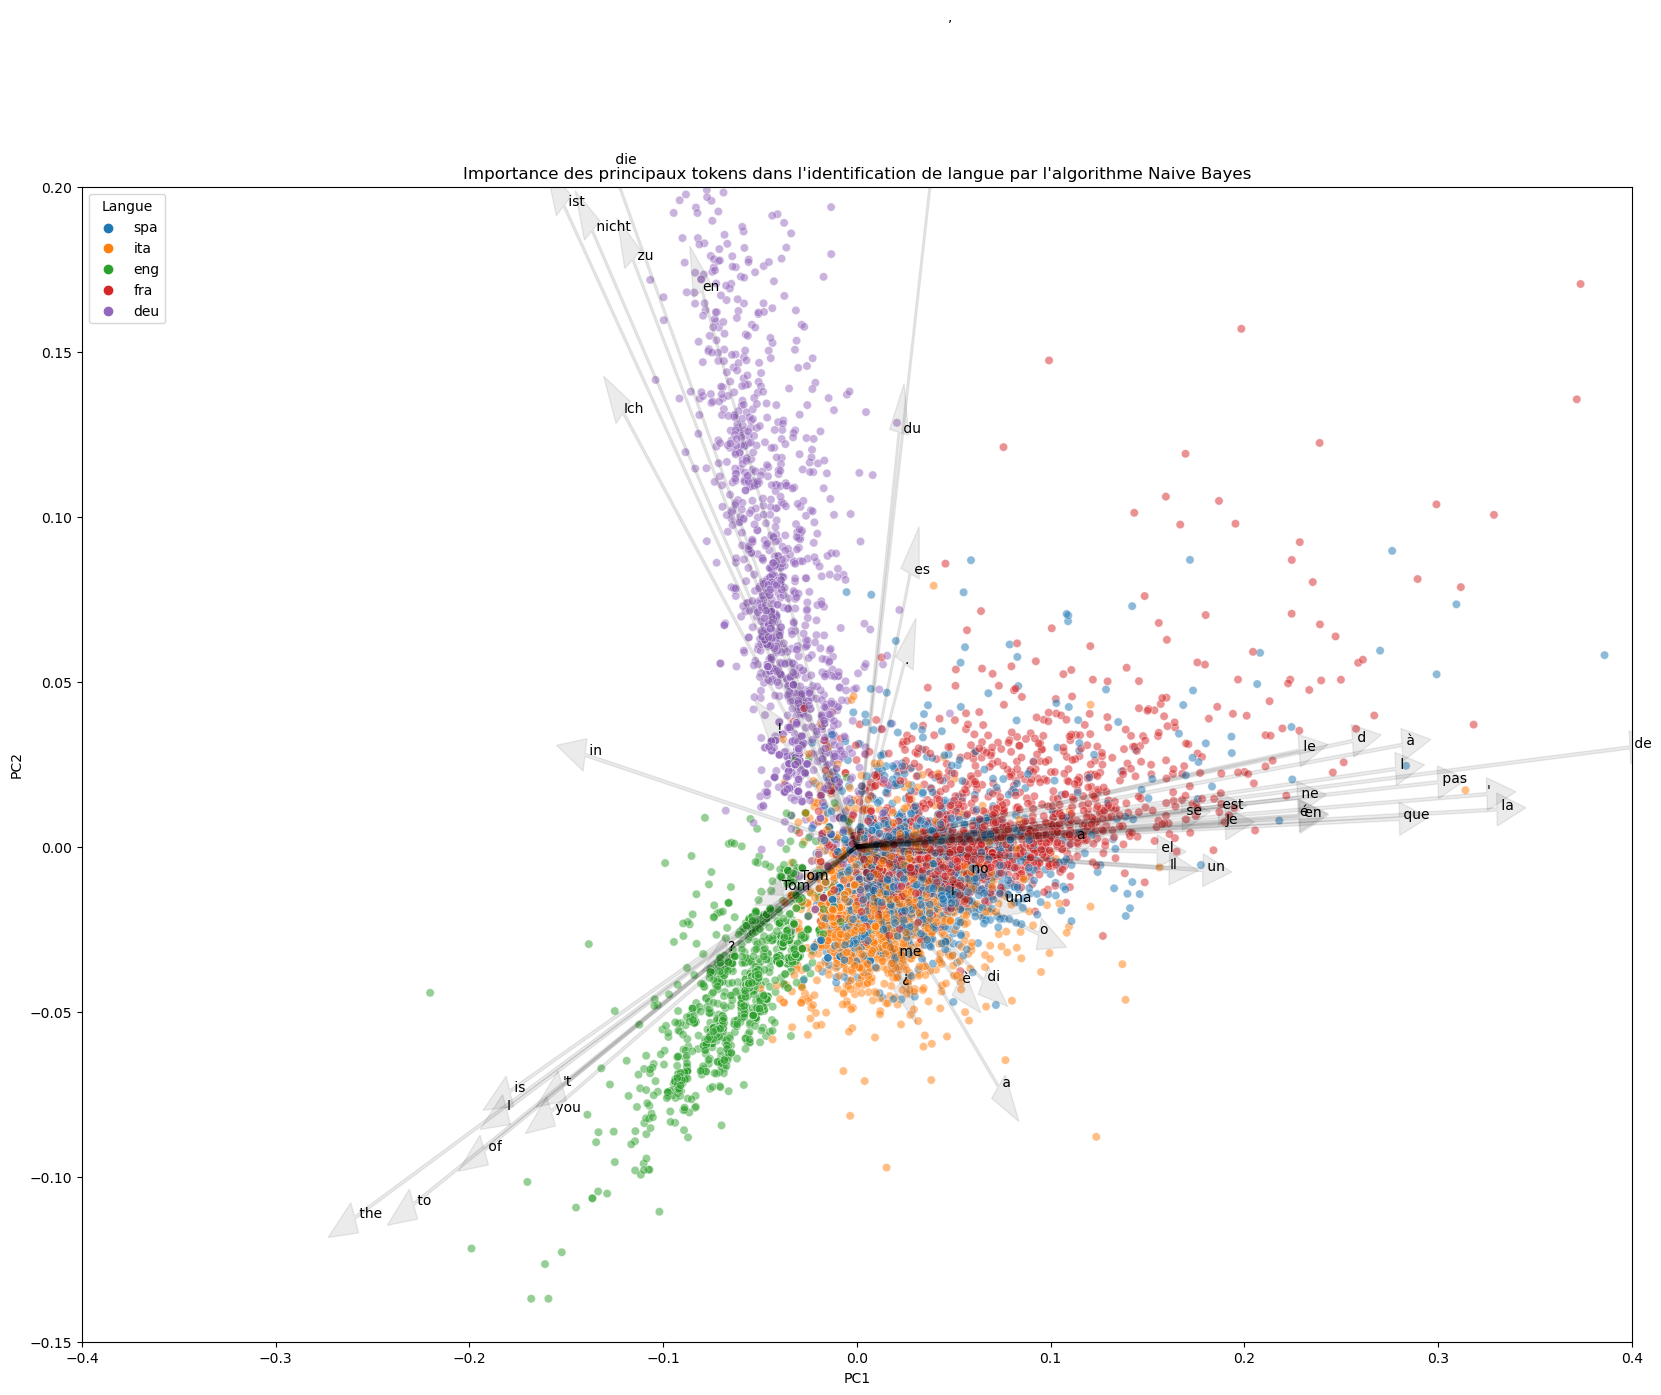

In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

# Definition du nombre maximum de lignes pris en compte et du nombre maximum de tokens
max_lines = 10000
max_cols = 100

# Calculer la somme de chaque colonne
sommes_colonnes = np.array(X_train.sum(axis=0)).flatten()

# Trier les indices des colonnes en fonction des sommes
indices_tries = np.argsort(sommes_colonnes)[::-1]

# Réorganiser les colonnes dans la sparse matrix en fonction des indices triés
X_train_sorted = X_train[:, indices_tries]

pd_X_train = pd.DataFrame(data=X_train_sorted[:max_lines,:max_cols].todense(), columns = decoded_keys[:max_cols])
# pd_X_train = pd.DataFrame(data=X_train, columns = decoded_keys)

n = pd_X_train.shape[1]

pca = PCA(n_components=2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(pd_X_train)

X_new = pca.fit_transform(X_train_scaled)

coeff = pca.components_.transpose()

xs = X_new[:, 0]
ys = X_new[:, 1]
scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())


principalDf = pd.DataFrame({'PC1': xs*scalex, 'PC2': ys * scaley})

y_train_pred = clf_nb.predict(X_train)
finalDF = pd.concat([principalDf, pd.Series(
    y_train_pred, name='Langue')], axis=1)


plt.figure(figsize=(20, 15))

sns.scatterplot(x='PC1', y='PC2', hue='Langue', data=finalDF, alpha=0.5)

for i in range(min(n,50)):
    plt.arrow(0, 0, coeff[i, 0]*1.5, coeff[i, 1]*0.8,
              color='k', alpha=0.08, head_width=0.01, )
    plt.text(coeff[i, 0]*1.5, coeff[i, 1] * 0.8, pd_X_train.columns[i], color='k')


plt.title("Importance des principaux tokens dans l'identification de langue par l'algorithme Naive Bayes") 
plt.xlim(-0.4, 0.4);
plt.ylim(-0.15, 0.2);

#### **Création d'un DataFrame BOW Train avec les Token ID en colonne + le lan_code**

In [20]:
col_name = col2ids(range(nb_token))
df_BOW = pd.DataFrame.sparse.from_spmatrix(data=X_train, columns=col_name)
df_BOW['lan_code']=y_train
display(df_BOW.head())

,0,1,2,3,4,5,6,7,8,9,...,100227,100231,100235,100236,100243,100246,100248,100252,100254,lan_code
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,spa
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ita
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,eng
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,eng
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,spa


#### **Définition de fonction de réduction de la taille des BOW en fonction de la phrase analysée/interprétée**
> Fonnctionnalités nécéssaires pour diminuer la taille de la mémoire utilisée

In [21]:
# Cette fonction permet de créer un mini BOW pour X_train
def downsize_dataframe(df_BOW,token_used):
    df_small = df_BOW[token_used]
    col_name = [tokenizer.decode([int(token_used[i])]) for i in range(len(token_used))]
    df_small.columns = col_name
    df_small['lan_code'] = df_BOW['lan_code'] #.tolist()
    df_small = df_small.loc[~(df_small[col_name] == 0).all(axis=1)]
    y_small = df_small['lan_code'].tolist()
    df_small = df_small.drop(['lan_code'], axis=1)
    return df_small, y_small

# Cette fonction trouve les tokens utilisés pour encoder la phrase à tester
def find_token_used(sentence,n_added_token=0):
    encodage = tokenizer.encode(sentence)
    # Trouve les token utilisés pour la phrase
    token_used = sorted(set([encodage[i] for i in range(len(encodage)) if encodage[i] in dict_ids]))
    # On y ajoute quelques token fréquent ne se trouvant pas dans la phrase pour faciliter certaine analyse (dont Lime)
    token_used = list(set(token_used + [dict_token[t] for t in list(dict_freq.keys())[:n_added_token]]))
    return token_used

# Cette fonction permet de créer un mini BOW pour la phrase à tester
def create_BOW_with_only_used_token(data, token_used):
    BOW = []
    for ligne in data:
        # l_tokenised = vectorizer.transform([ligne]).todense()
        l_tokenised = tokenizer.encode(ligne)
        BOW.append([l_tokenised.count(token) for token in token_used])
    return BOW

# Cette fonction utilise les fonctions précédentes pour fournir un jeu de données réduit à partir d'une phrase selectionnée
def reduce_data(sentence,n_added_token=0 ):
    # trouve les tokens nécéssaires pour encoder la phrase
    token_used= find_token_used(exemples[sel_phrase],n_added_token)

    # Création du vecteur BOW de la phrase
    bow_sentence = create_BOW_with_only_used_token([sentence],  token_used)
    
    # Afin de continuer l'analyse on ne garde que les tokens de la phrase disponibles dans le BOW et les lignes non nulles
    df_BOW_short, y_train_short = downsize_dataframe(df_BOW, token_used)
    return bow_sentence, df_BOW_short, y_train_short

#### **Exemples d'utilisation**

In [22]:
# Instanciation d'un exemple
exemples = ["Er weiß überhaupt nichts über dieses Buch.",                                                             # Phrase 0
            "france is often snowy during spring , and it is relaxing in january .",                                  # Phrase 1
           "elle adore les voitures très luxueuses, et toi ?",                                                        # Phrase 2
           "she loves very luxurious cars, don't you?",                                                               # Phrase 3
           "vamos a la playa",                                                                                        # Phrase 4
           "Ich heiße Keyne, und das ist wunderbar",                                                                  # Phrase 5
           "she loves you much, mais elle te hait aussi and das ist traurig.", # Attention à cette phrase trilingue   # Phrase 6
           "A crane raises heavy construction materials.",                                                            # Phrase 7
           "Vogliamo visitare il Colosseo e nuotare nel Tevere."                                                      # Phrase 8
          ]
lang_exemples = ['deu','eng','fra','eng','spa','deu','en,fr,de','en','ita']

In [23]:
# Affichage des prédictions
print('Langue réelle                 :',lang_exemples)
print('Prédictions Naive Bayes       :',lang_id_nb(exemples))
print('Prédictions Gradiant Boosting :',lang_id_gb(exemples))

Langue réelle                 : ['deu', 'eng', 'fra', 'eng', 'spa', 'deu', 'en,fr,de', 'en', 'ita']
Prédictions Naive Bayes       : ['deu' 'eng' 'fra' 'eng' 'spa' 'deu' 'fra' 'eng' 'ita']
Prédictions Gradiant Boosting : ['deu' 'eng' 'fra' 'eng' 'spa' 'deu' 'deu' 'spa' 'ita']


#### **Selection de la phrase exemple à analyser**

In [24]:
sel_phrase = 6

#### **Algorithme LIME appliqué à une phrase mal classée par Naive Bayes**

In [25]:
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

# Choix de la ligne d'exemple
# sel_phrase = 6

# trouve les tokens nécéssaires pour encoder la phrase
# token_used= find_token_used(exemples[sel_phrase],1)

feat, df_BOW_small, y_small = reduce_data(exemples[sel_phrase],1)
features = np.array(feat)
    
# Nous reconstruisons le même modèle mais avec des numpy arrays pour éviter les problèmes avec LIME du au noms des features
exp = LimeTabularExplainer(features, feature_names=df_BOW_small.columns, class_names=['deu', 'eng','fra','ita','spa'])

# Recréation d'un classifieur avec les données réduites
clf_nb_small = naive_bayes.MultinomialNB()
clf_nb_small.fit(df_BOW_small, y_small)

print("Phrase :",exemples[sel_phrase])
print('Predicted Label:',clf_nb_small.predict(feat)," / probabilités = ",[round(e,3) for e in clf_nb_small.predict_proba(features)[0]])
exp.explain_instance(features[0], clf_nb_small.predict_proba, top_labels=20).show_in_notebook()

Phrase : she loves you much, mais elle te hait aussi and das ist traurig.
Predicted Label: ['fra']  / probabilités =  [0.0, 0.0, 1.0, 0.0, 0.0]


#### **Décompostion et interprétation du processus d'identification d'une langue avec Naïve Bayes**

#### 1- Calcul du nombre d'apparitions des tokens dans chaque langue
#### 2- Calcul de la probabilité d'apparition de chaque token dans chaque langue 
#### 3- Calcul (par multiplication) de la probabilité d'appartenance de la phrase à une langue
![Formule probabilité Naïve Bayes](../images/formule_proba_naive_bayes.png)
> où **C** est la classe (*lan_code*), **Fi** est la *caractéristique i* du BOW, **Z** est l'*"evidence"* servant à regulariser la proba 

Phrase à analyser : en,fr,de - "she loves you much, mais elle te hait aussi and das ist traurig.
Nombre de tokens dans la phrase: 18
Nombre de tokens retenus dans le BOW: 18
Tokens retenus (se trouvant dans le modèle) :she  loves  you  much ,  mais  elle  te  h ait  aussi  and  das  ist  tr aur ig . 

Nombre d'apparitions des tokens retenus,  dans chaque langue


,1-she,2- loves,3- you,4- much,"5-,",6- mais,7- elle,8- te,9- h,10-ait,11- aussi,12- and,13- das,14- ist,15- tr,16-aur,17-ig,18-.
eng,2,272,31144,2600,26723,0,0,46,185,11,0,13216,0,0,61,31,48,216705
fra,0,0,2,0,32085,3619,2236,5086,1201,9845,2012,14,1,0,969,891,721,202786
deu,2,0,1,0,78697,0,0,463,4876,16,0,500,18753,39402,2131,293,9277,202872
spa,0,0,2,862,27969,0,3,6367,3387,9,0,364,96,0,1737,23,1318,207886
ita,0,0,1,0,17098,6,0,2339,15,17,0,5996,0,204,1136,65,1420,189103


Probabilité d'apparition tokens retenus, dans chaque langue


,1-she,2- loves,3- you,4- much,"5-,",6- mais,7- elle,8- te,9- h,10-ait,11- aussi,12- and,13- das,14- ist,15- tr,16-aur,17-ig,18-.,Proba
eng,8.168733e-06,1.110948e-03,0.127204,1.061935e-02,0.109147,1.000000e-11,1.000000e-11,0.000188,0.000756,0.000045,1.000000e-11,0.053979,1.000000e-11,1.000000e-11,0.000249,0.000127,0.000196,0.885103,0.0
fra,1.000000e-11,1.000000e-11,0.000008,1.000000e-11,0.130713,1.474369e-02,9.109390e-03,0.020720,0.004893,0.040108,8.196821e-03,0.000057,4.073967e-06,1.000000e-11,0.003948,0.003630,0.002937,0.826143,1.0
deu,8.172038e-06,1.000000e-11,0.000004,1.000000e-11,0.321557,1.000000e-11,1.000000e-11,0.001892,0.019923,0.000065,1.000000e-11,0.002043,7.662511e-02,1.609973e-01,0.008707,0.001197,0.037906,0.828939,0.0
spa,1.000000e-11,1.000000e-11,0.000008,3.519761e-03,0.114204,1.000000e-11,1.224975e-05,0.025998,0.013830,0.000037,1.000000e-11,0.001486,3.919919e-04,1.000000e-11,0.007093,0.000094,0.005382,0.848850,0.0
ita,1.000000e-11,1.000000e-11,0.000004,1.000000e-11,0.069770,2.448350e-05,1.000000e-11,0.009544,0.000061,0.000069,1.000000e-11,0.024467,1.000000e-11,8.324390e-04,0.004636,0.000265,0.005794,0.771651,0.0


       deu      eng      eng      eng      deu      fra      fra      spa      deu      fra      fra      eng      deu      deu      deu      fra      deu      eng      fra      


Langue réelle de la phrase                         :  en,fr,de
Langue dont la probabilité est la plus forte       :  fra  (proba=1.00)
Langue dont la probabilité prédite par Naiva Bayes :  fra  (proba=1.00)



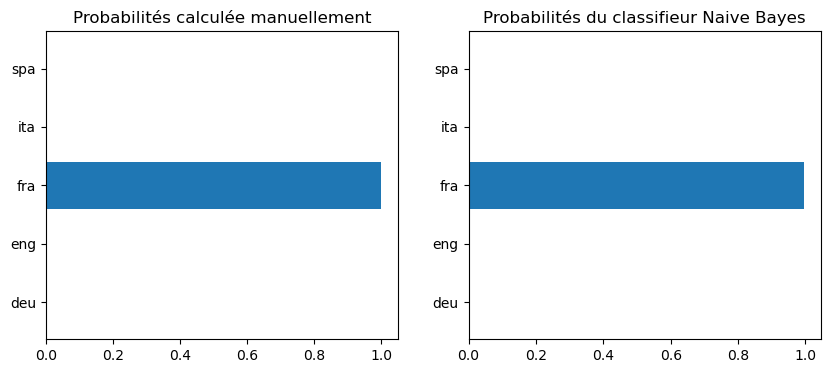

In [26]:
#########
######### 2. Selection d'une phrase et encodage uniquement avec les tokens du BOW

# Selection de la phrase à analyser
#sel_phrase = 8
print("Phrase à analyser :\033[31;46m",lang_exemples[sel_phrase],'- "'+exemples[sel_phrase]+'\033[0m')

# Tokenisation et encodage de la phrase
encodage = tokenizer.encode(exemples[sel_phrase])
print("Nombre de tokens dans la phrase:",len(encodage))

# Création du vecteur BOW de la phrase
bow_exemple = create_BOW([exemples[sel_phrase]])
print("Nombre de tokens retenus dans le BOW:",np.sum(bow_exemple.getrow(0).toarray()))
masque_tokens_retenus = [(1 if token in list(dict_ids.keys()) else 0) for token in encodage]
print("Tokens \033[96;43mretenus\033[0m (se trouvant dans le modèle) :",end="")
for i in range(len(encodage)):
    if masque_tokens_retenus[i]==1:
        print("\033[96;43m"+tokenizer.decode([encodage[i]])+"\033[0m ",end="")
    else: print("\033[31;47m"+tokenizer.decode([encodage[i]])+"\033[0m ",end="")

print("")
# Afin de continuer l'analyse on ne garde que les token de la phrase disponibles dans le BOW
token_used = [encodage[i] for i in range(len(encodage)) if (masque_tokens_retenus[i]==1)]


# Calcul du nombre d'apparition de ces tokens dans le BOW pour chaque langue, et stockage dans un DataFrame df_count
def compter_non_zero(colonne):
    return (colonne != 0).sum()

votes = []
for i in range(len(lan_code)):
    #votes.append(list(df_BOW[token_used].loc[df_BOW['lan_code']==lan_code[i]].sum(axis=0)))
    votes.append(list(df_BOW[token_used].loc[df_BOW['lan_code']==lan_code[i]].apply(compter_non_zero)))

col_name = [str(i+1)+'-'+tokenizer.decode([int(token_used[i])]) for i in range(len(token_used))]
df_count = pd.DataFrame(data=votes,columns=token_used, index=lan_code)
df_count.columns = col_name
print("\nNombre d'apparitions des tokens retenus,  dans chaque langue")
display(df_count)

#########
######### 3. Calcul de la probabilité d'apparition de chaque token dans chaque langue
df_proba = df_count.div(nb_phrases_lang, axis = 0)

# Calcul (par multiplication) de la probabilité d'appartenance de la phrase à une langue
df_proba['Proba'] = 1
# Itérer sur les colonnes et effectuez la multiplication pour chaque ligne
df_proba = df_proba.replace(0.0,0.00000000001) # 0.0000009)
for col in df_count.columns:
    df_proba['Proba'] *= df_proba[col]

#########    
######### 4.  Calcul (par multiplication) de la probabilité d'appartenance de la phrase à une langue

# Multiplication par la probabilité de la classe
p_classe = [(nb_phrases_lang[i]/df_BOW.shape[0]) for i in range(len(nb_phrases_lang))]
df_proba['Proba'] *= p_classe

# Diviser par l'evidence
evidence = df_proba['Proba'].sum(axis=0)
df_proba['Proba'] *= 1/evidence
df_proba['Proba'] = df_proba['Proba'].round(3)

# Affichage de la matrice des probabilités
print("Probabilité d'apparition tokens retenus, dans chaque langue")
display(df_proba)
color = { 'deu':'\033[316;43m','eng':'\033[32;47m','fra':'\033[95;44m','ita':'\033[94;46m','spa':'\033[93;47m'}
print("      ",end=" ")
for i,token in enumerate(df_proba.columns):
    print(color[df_proba[token].idxmax()]+df_proba[token].idxmax(),end="\033[0m      ")
print("\n\n")

print("Langue réelle de la phrase                         : ",lang_exemples[sel_phrase])
print("Langue dont la probabilité est la plus forte       : ",df_proba['Proba'].idxmax()," (proba={:.2f}".format(max(df_proba['Proba']))+")")
prediction = clf_nb.predict(bow_exemple) 
print("Langue dont la probabilité prédite par Naiva Bayes : ",prediction[0]," (proba={:.2f}".format(max(clf_nb.predict_proba(create_BOW([exemples[sel_phrase]]))[0]))+")")
print("")

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
df_proba_sorted =df_proba.sort_index(ascending=True)
axs[0].set_title("Probabilités calculée manuellement")
axs[0].barh(df_proba_sorted.index, df_proba_sorted['Proba'])
axs[1].set_title("Probabilités du classifieur Naive Bayes")
axs[1].barh(df_proba_sorted.index, clf_nb.predict_proba(create_BOW([exemples[sel_phrase]]))[0]);

#### **Analyse, avec Skater, des tokens ayant le plus d'impact sur l'identification de la langue**

she loves you much, mais elle te hait aussi and das ist traurig.   prédite ->  ['fra']
Importance des tokens dans l'identification de la langue, selon SKATER
[18/18] features ████████████████████ Time elapsed: 0 seconds

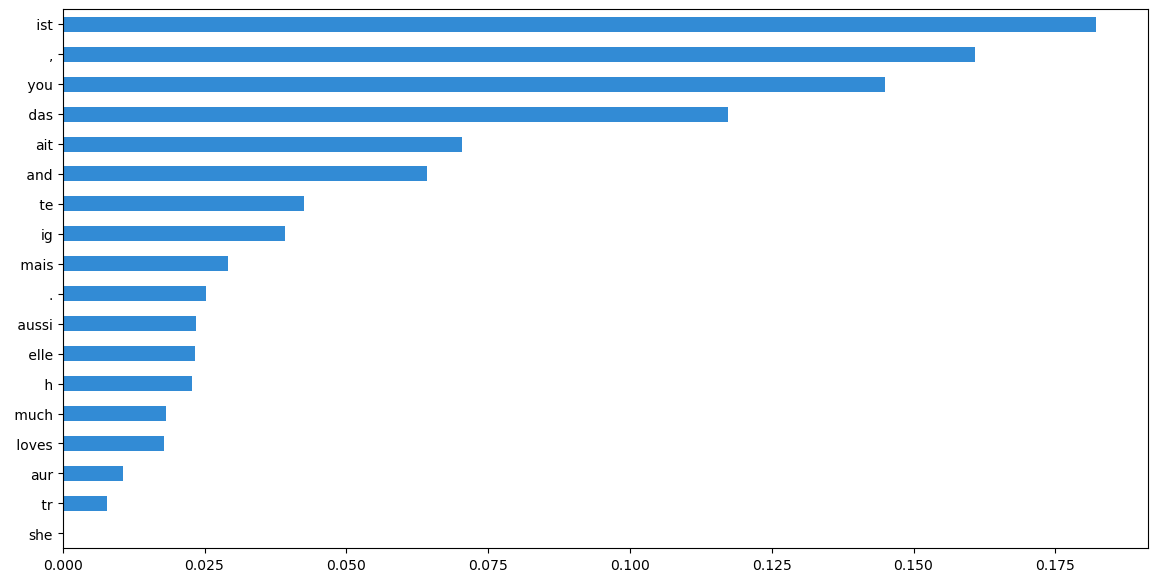

In [27]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
import matplotlib.pyplot as plt

# Selection de la phrase à analyser
# sel_phrase = 0
bow_exemple, df_BOW_small, y_small = reduce_data(exemples[sel_phrase])

# Préparation de l'interpretation
interpreter = Interpretation(df_BOW_small.iloc[:4000], feature_names=df_BOW_small.columns )
clf = naive_bayes.MultinomialNB()
clf.fit(df_BOW_small, y_small)
model = InMemoryModel(clf.predict_proba, examples = np.array(df_BOW_small.iloc[:4000])) #bow_exemple)) # df_BOW_small)

print(exemples[sel_phrase],"  prédite -> ",clf.predict(bow_exemple))
plt.rcParams['figure.figsize'] = (14,7)
print("Importance des tokens dans l'identification de la langue, selon SKATER")
plots = interpreter.feature_importance.plot_feature_importance(model, ascending=False)

#### **Analyse de l'importance de chaque token dans l'identification de chaque langue, grâce à aux valeurs de Shapley**

In [28]:
import shap
from sklearn.preprocessing import MinMaxScaler

# Selection de la phrase à analyser
# sel_phrase = 8
bow_exemple, df_BOW_small, y_small = reduce_data(exemples[sel_phrase])

nb_lines = 4000
# sc = MinMaxScaler()
X_train_new = df_BOW_small.iloc[:nb_lines ] 
X_test_new = bow_exemple 
X_train_trans = pd.DataFrame(X_train_new, columns=df_BOW_small.columns)
X_test_trans = pd.DataFrame(X_test_new, columns=df_BOW_small.columns)
classifier = naive_bayes.MultinomialNB() 
classifier.fit(X_train_trans.values, y_small[:nb_lines])

explainer = shap.KernelExplainer(classifier.predict_proba, X_train_trans) #kernel explainer requires background dataset 
                                                                        #which can be our train dataset. to generate perturb features
SHAP_values = explainer.shap_values(X_test_trans)
shap.initjs()

print(' '*30+"\033[1mValeurs de Shapley: Influence des tokens sur la selection de la langue\033[0m")
print(' '*30+"\033[1m======================================================================\033[0m")
print(' '*30+"\033[1mAllemand\033[0m")
display(shap.force_plot(explainer.expected_value[0], SHAP_values[0], X_test_trans)) # deu
print(' '*30+"\033[1mAnglais\033[0m")
display(shap.force_plot(explainer.expected_value[1], SHAP_values[1], X_test_trans)) # eng
print(' '*30+"\033[1mFrançais\033[0m")
display(shap.force_plot(explainer.expected_value[2], SHAP_values[2], X_test_trans)) # fra
print(' '*30+"\033[1mItalien\033[0m")
display(shap.force_plot(explainer.expected_value[3], SHAP_values[3], X_test_trans)) # ita
print(' '*30+"\033[1mEspagnol\033[0m")
display(shap.force_plot(explainer.expected_value[4], SHAP_values[4], X_test_trans)) # spa

Using 4000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

                              Valeurs de Shapley: Influence des tokens sur la selection de la langue
                              Allemand


                              Anglais


                              Français


                              Italien


                              Espagnol


#### **Recapitulatif, avec les valeurs de Schapley, de l'influence des tokens sur la selection de la langue**

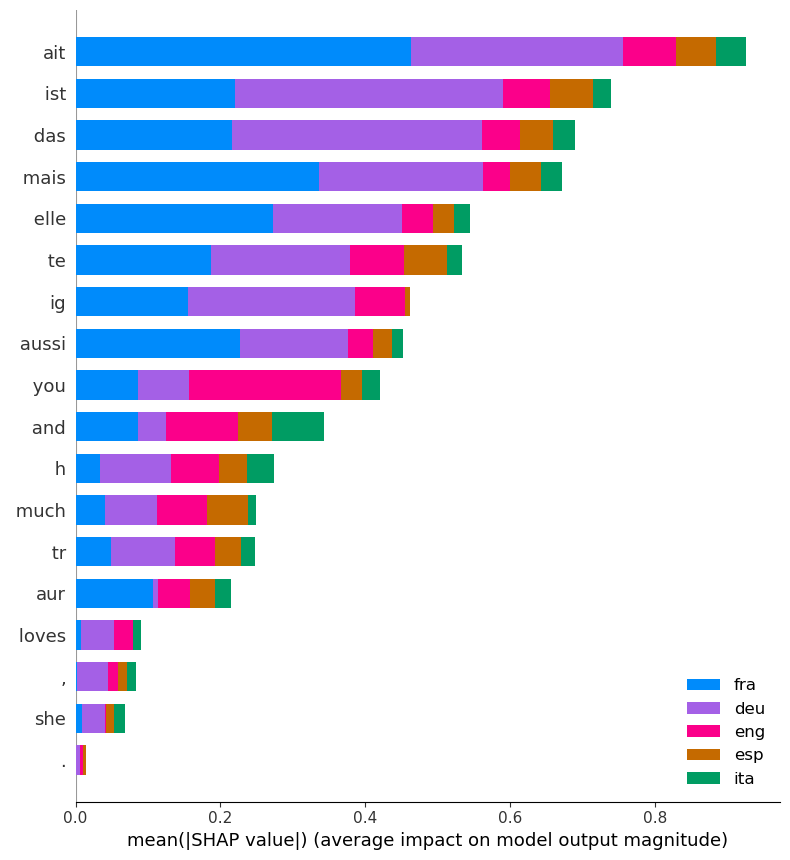

In [29]:
shap.summary_plot(SHAP_values, X_test_trans,title="Recapitulatif de l'influence des tokens sur la selection de la langue",
                 class_names=['deu','eng','fra','ita','esp']) 

> **Recherche des phrases mal classées par Naive Bayes**

In [30]:
n_bad_max = 30
n_bad = 0
for i in range(len(y_test)):
    if (y_test[i] != y_pred_nb[i]) and (n_bad<n_bad_max):
        n_bad +=1
        print(n_bad,'- No',i,' - Réel:',y_test[i],' Prédit:',y_pred_nb[i],'    ',df_test['sentence'].iloc[i]," (proba={:.2f}".format(max(clf_nb.predict_proba(create_BOW([df_test['sentence'].iloc[i]]))[0]))+")")


1 - No 891  - Réel: spa  Prédit: ita      Casi cedo.  (proba=0.95)
2 - No 1469  - Réel: spa  Prédit: ita      Maullido.  (proba=0.73)
3 - No 1614  - Réel: fra  Prédit: spa      La jupe est verte.  (proba=0.91)
4 - No 2469  - Réel: spa  Prédit: fra      La vaca muge.  (proba=0.72)
5 - No 2787  - Réel: ita  Prédit: spa      Tom tiene un diario.  (proba=0.78)
6 - No 3118  - Réel: spa  Prédit: ita      Amo a Hitomi.  (proba=0.97)
7 - No 4176  - Réel: spa  Prédit: ita      Te propongo un trato.  (proba=0.91)
8 - No 4544  - Réel: ita  Prédit: spa      Es completamente blanco.  (proba=1.00)
9 - No 5020  - Réel: spa  Prédit: ita      Queda uno.  (proba=0.52)
10 - No 5068  - Réel: eng  Prédit: ita      Datu visited Alvin.  (proba=0.90)
11 - No 5836  - Réel: eng  Prédit: spa      Tom burped.  (proba=0.80)
12 - No 6014  - Réel: fra  Prédit: spa      « Macunaíma » est lancé en 1928.  (proba=0.93)
13 - No 6101  - Réel: fra  Prédit: spa      Tom a perdu espoir.  (proba=0.46)
14 - No 7415  - Réel: sp